In [51]:
import math
import scipy
import numpy as np
import matplotlib.pyplot as plt
import torch 
from typing import List

/home/nemo/anaconda3/envs/BARF/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def discrete_gaussian_kernel(t, n):
    return math.exp(-t) * scipy.special.iv(n, t)

In [3]:
def get_gaussian_diff_kernel(t, ns: int):
        # create and return the parater used as sigma.
        sigma = torch.tensor(t)
        ns = torch.tensor(list(ns))
        exponent = - 0.5 * (ns / max(sigma,0.01)) * (ns / max(sigma,0.01))
        kernel = 1/max(sigma*math.sqrt(2*math.pi), 1) * torch.exp(exponent)
        return kernel

In [40]:
def plot_kernel(ts: List[float], n: int, kernel):
    assert(n%2 == 1)
    ns = range(-(n//2), n//2+1)
    print(ns)
    ys = [kernel(t, ns) for t in ts]
    plt.plot(*(ns if k%2==0 else ys[k//2] for k in range(len(ts)*2)))
    plt.xlim([-n//2, n//2+1])

range(-5, 6)


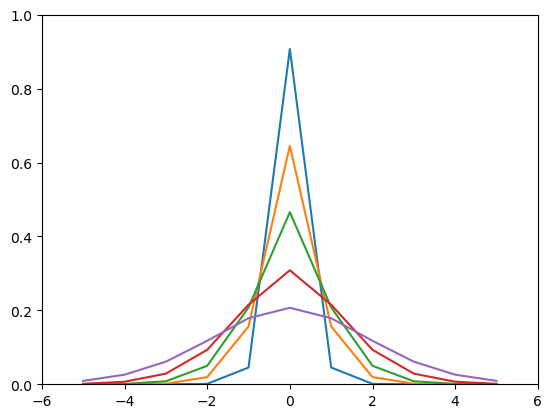

In [5]:
plot_kernel([0.1, 0.5, 1,2,4], 11, discrete_gaussian_kernel)

range(-10, 11)


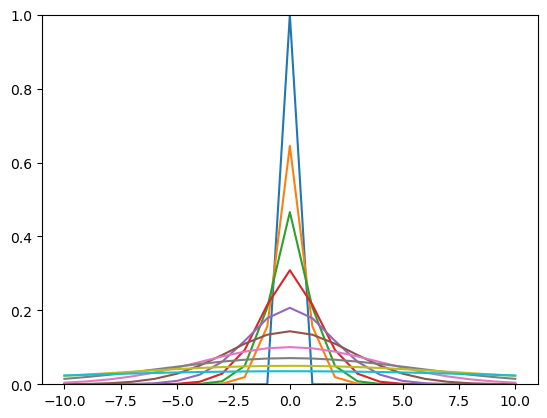

In [6]:
plot_kernel([0, 0.5, 1,2,4,8, 16, 32, 64, 128], 21, discrete_gaussian_kernel)

range(-5, 6)


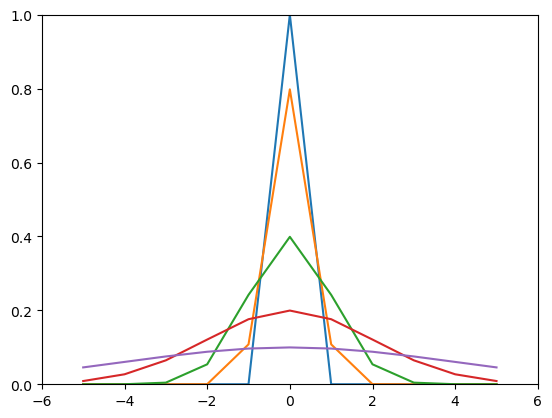

In [7]:
plot_kernel([0.1, 0.5, 1,2,4], 11, get_gaussian_diff_kernel)

range(-255, 256)


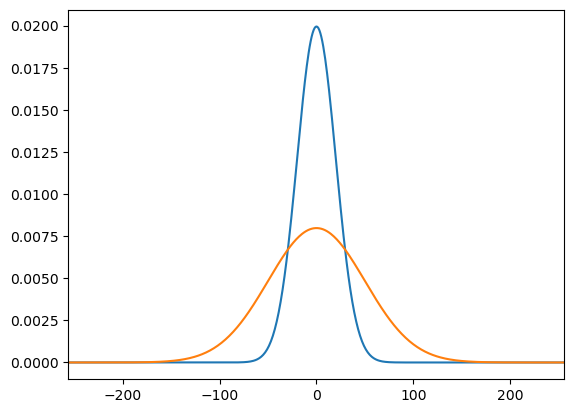

In [48]:
plot_kernel([20, 50], 511, get_gaussian_diff_kernel)

In [107]:
def combined_Kernel(t,ns, combine_levels = 5):
    kernels = torch.stack(tuple(get_gaussian_diff_kernel(t * 2**i, ns) for i in range(combine_levels)))
    #weights = torch.ones(combine_levels).unsqueeze(1)
    weights = torch.arange(1,combine_levels+1,1).unsqueeze(1)
    weights = weights
    weights = weights / torch.sum(weights)
    kernels = kernels * weights
    kernels = torch.sum(kernels, dim=0)
    return kernels

range(-127, 128)


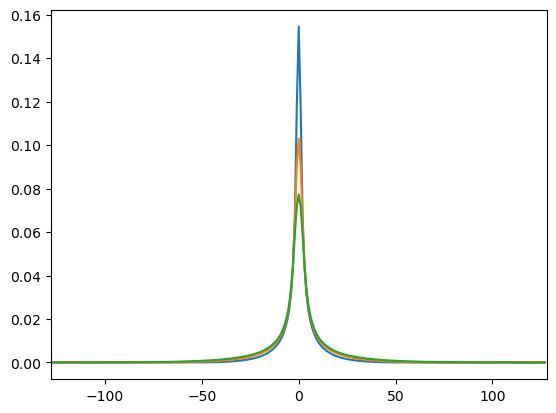

In [109]:
plot_kernel([1.0, 1.5 , 2.0,], 255, lambda t, ns: combined_Kernel(t, ns, combine_levels=5))

In [65]:
t_range = 100
s_range = 100
t_step = 0.1
s_step = 1

ts = torch.arange(-t_range, t_range+1, t_step ).unsqueeze(0)
ss = torch.fft.fftshift(torch.fft.fftfreq(s_range*2+1)).unsqueeze(1)

def show_ticks():
    plt.xticks(np.linspace(0, t_range*2 * int(1/t_step), 21), map(lambda x: f"{float(x):.0f}",ts.squeeze()[::ts.shape[1]//20]))
    plt.yticks(np.linspace(0, 2*s_range * int(1/s_step), 21), map(lambda x: f"{float(x):.2f}",ss.squeeze()[::ss.shape[0]//20]))
    ax = plt.gca()
    ax.set_aspect('auto', adjustable='box')
    plt.xlabel("t")
    plt.ylabel("s")

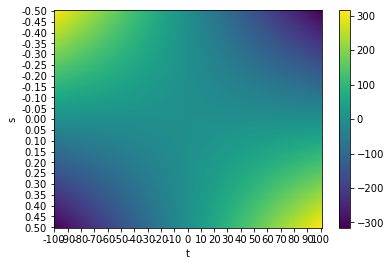

In [66]:
base = 2 * torch.pi * ss * ts
plt.imshow(base,interpolation="none")
show_ticks()
plt.colorbar()

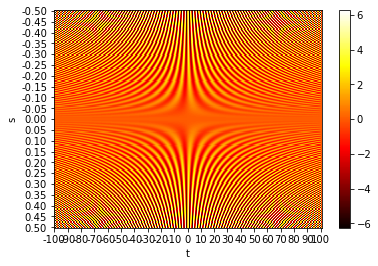

In [106]:
# color space = heat map
transfer = torch.pi * 4 * ss *(torch.sin(base))#-torch.sin(2 * base))
plt.imshow((transfer), cmap="hot", interpolation="none")
plt.colorbar()
show_ticks()

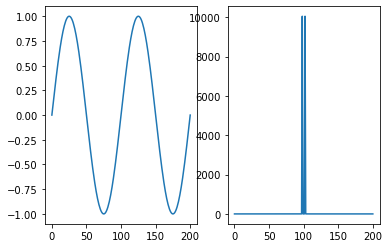

In [100]:
xs = torch.arange(0,201)
f = torch.sin(xs*2*math.pi*2/200)
# f is a 1D signal
# plot the time and frequency domain of f side by side, in line chart
plt.subplot(1,2,1)
plt.plot(xs, f)
plt.subplot(1,2,2)
f_freq = torch.fft.fft(f)

f_freq = torch.fft.fftshift(abs(f_freq)**2)
plt.plot(xs,f_freq)

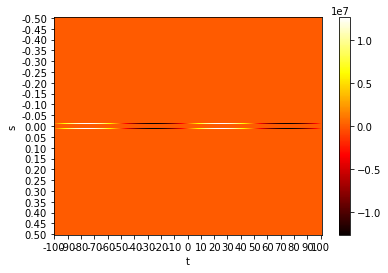

In [104]:
grad = transfer * (torch.abs(f_freq)**2).unsqueeze(1)
plt.imshow(grad, interpolation="none", cmap="hot")
show_ticks()
plt.colorbar()

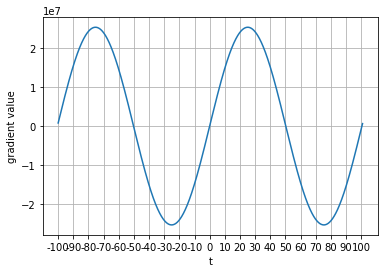

In [103]:
# plot 1D gradient value along t displacement
grad_1d = torch.sum(grad, dim=0)
plt.plot(grad_1d)
plt.xlabel("t")
plt.ylabel("gradient value")
plt.xticks(np.linspace(0, t_range*2 * int(1/t_step), 21), map(lambda x: f"{float(x):.0f}",ts.squeeze()[::ts.shape[1]//20]))
plt.grid()